# 1.  U-Net trained on public datasets
This notebook is for training a model on public data. The goal is to train a model that will be used to find cell instances in the data from the SweBCH91RT study.

In [5]:
import random
import json
import os
import time

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import tensorflow as tf

#gpu = tf.config.experimental.list_physical_devices("GPU")[0]
#tf.config.experimental.set_memory_growth(gpu, True)

import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from keras.models import Model, load_model
from keras.layers import Input, multiply
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import keras
import pandas as pd

import wandb
from wandb.keras import WandbCallback

from weighted_loss_unet import make_weighted_loss_unet, my_loss

import config
import importlib

importlib.reload(config)
c = config.Config()

## Data augmentation

In [6]:
import dataset
from augmented_dataset import AugmentedDataset
from dataset import Monuseg, Bns, Quip, TNBC2
import random

seq = iaa.Sequential(
    [
        #iaa.CropToFixedSize(width=round(c.WIDTH*4.0), height=round(c.HEIGHT*4.0)),
        #iaa.Resize({"height" : c.HEIGHT,  "width" : c.WIDTH}),
        #iaa.Affine(rotate=[0,90,180,270],
        #          scale=(0.7, 1.3)),
        iaa.CropToFixedSize(width=c.WIDTH, height=c.HEIGHT),
        # iaa.Sometimes(0.2, iaa.EdgeDetect((0,0.5)))
        #iaa.AddToHue((-25, 25))
    ]
)

f = lambda x : AugmentedDataset(Quip(2000), seq, 1, scale = 1.0).prefetch(tf.data.experimental.AUTOTUNE)
ds_train = tf.data.Dataset.range(1).interleave(
        f,
        num_parallel_calls=4
    )

ds_val, _ = Monuseg().make_split(0.5)
ds_val.aug_size = 30

## Sanity check

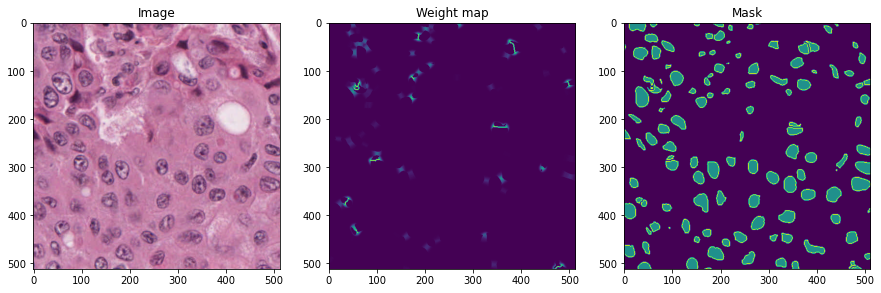

In [4]:
# Training set
for i in range(1):
    (img_b, wmap_b), mask_b = ds_train.as_numpy_iterator().__next__()
    for idx in range(1):
        img = img_b[idx]
        wmap = wmap_b[idx, ..., 0]
        mask = mask_b[idx, ..., 1]
        border = mask_b[idx, ..., 2]

        plt.figure(figsize=(15, 8))
        plt.subplot(131)
        plt.imshow(img)
        plt.title("Image")
        plt.subplot(132)
        plt.imshow(wmap)
        plt.title("Weight map")
        plt.subplot(133)
        plt.title("Mask")
        plt.imshow(mask + border*2)

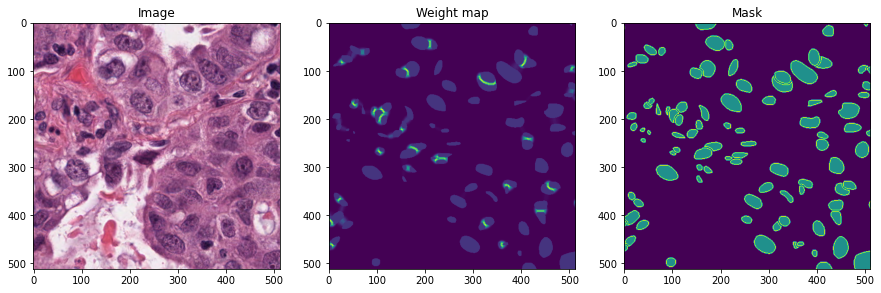

In [5]:
# Validation set
for (img_b, wmap_b), mask_b in list(ds_val)[0:1]:
    for idx in range(1):
        img = img_b[idx]
        wmap = wmap_b[idx, ..., 0]
        mask = mask_b[idx, ..., 1]
        border = mask_b[idx, ..., 2]

        plt.figure(figsize=(15, 8))
        plt.subplot(131)
        plt.imshow(img)
        plt.title("Image")
        plt.subplot(132)
        plt.imshow(wmap)
        plt.title("Weight map")
        plt.subplot(133)
        plt.title("Mask")
        plt.imshow(mask + border*2)

## Train U-Net
The U-Net, along with the weight map loss function, was implemented by [jaidevd](https://jaidevd.github.io/posts/weighted-loss-functions-for-instance-segmentation/).

In [7]:
notes = (
    """
    """)
name = f"quip2"
epochs = 1000
es = EarlyStopping(patience=10)
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
#opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.1, nesterov=False)

In [8]:
# tf.compat.v1.disable_eager_execution()
model_dir = "../models/unet"
os.makedirs(model_dir, exist_ok=True)
if f"{name}.h5" in os.listdir(model_dir):
    print("Loading existing model...", end="")
    model = keras.models.load_model(
        f"{model_dir}/{name}.h5", custom_objects={"my_loss": my_loss}
    )
    print("Done!")
else:
    wandb.init(project="histosnet", name=name, notes=notes)
    model = make_weighted_loss_unet(is_training=True)
    model.compile(optimizer=opt, loss=my_loss)
    try:
        model.fit(ds_train,
                  validation_data = ds_val,
                  epochs=epochs,
                  callbacks=[WandbCallback()])
    except KeyboardInterrupt:
        time_str = time.strftime("%Y%m%d-%H%M%S")
        name += f"_aborted_{time_str}"
    model.save(os.path.join(wandb.run.dir, "model.h5"))
    # Our inference model won't take a weight map as an input.
    model_inference = make_weighted_loss_unet(is_training=False)
    model_inference.set_weights(model.get_weights())
    model_inference.save(f"{model_dir}/{name}.h5")
    model = model_inference

Loading existing model...WARNING:tensorflow:No training configuration found in the save file, so the model was *not* compiled. Compile it manually.
Done!


## Predict of validation set

In [9]:
import skimage.morphology as morphology
from scipy.optimize import minimize
from itertools import islice
import predict
importlib.reload(predict)
from predict import post_processing

def iou(true, pred):
    intersection = np.logical_and(true, pred).sum()
    union = np.logical_or(true, pred).sum()
    return intersection / union 


In [10]:
def mean_iou(dataset, n_samples):
    iou_all = []
    for ((img_b, _), mask_b) in random.choices(dataset, k=n_samples):
        prediction = model.predict(img_b)
        for img, mask, pred in zip(img_b, mask_b, prediction):
            true = mask[...,1] + mask[...,2]
            pred = post_processing(pred[...,1], cutoff, size_limit)
            iou_all.append(iou(true, pred))
    return np.nanmean(iou_all)

cutoff = 0.2
size_limit = 5

In [7]:
import random 

def display_result(model, aug_sequence, batch_limit=3):
    for ((img_b, _), mask_b) in random.choices(aug_sequence, k=batch_limit):
        prediction = model.predict(img_b)
        for img, mask, pred in zip(img_b, mask_b, prediction):
            y_true = mask[...,1] + mask[...,2]
            plt.figure(figsize=(15, 8))
            plt.tight_layout()
            plt.subplot(141)
            plt.imshow(img)
            plt.title("Image")

            plt.subplot(142)
            plt.imshow(y_true)
            plt.title("Ground Truth")

            plt.subplot(143)
            plt.imshow(pred[:, :, 1])
            plt.title("Predicted")

            plt.subplot(144)
            pred = post_processing(pred[..., 1], cutoff, size_limit)
            plt.imshow(pred)
            plt.title(f"IoU: {round(iou(pred, y_true), 2)}")

### MoNuSeg

Mean IOU: 0.663


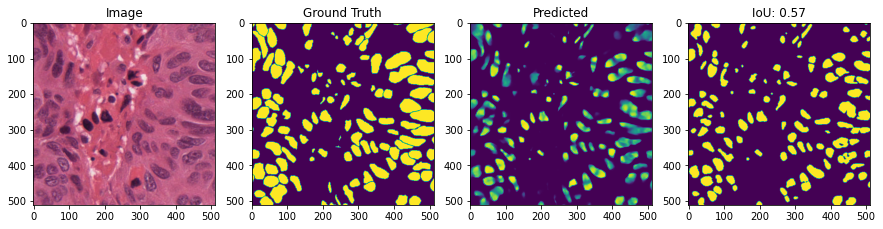

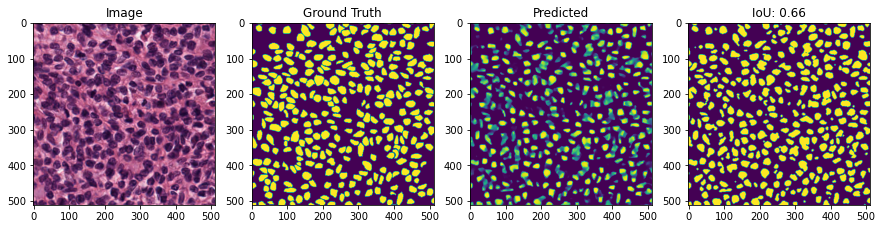

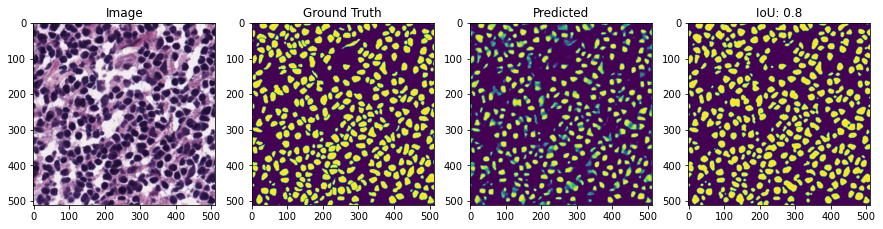

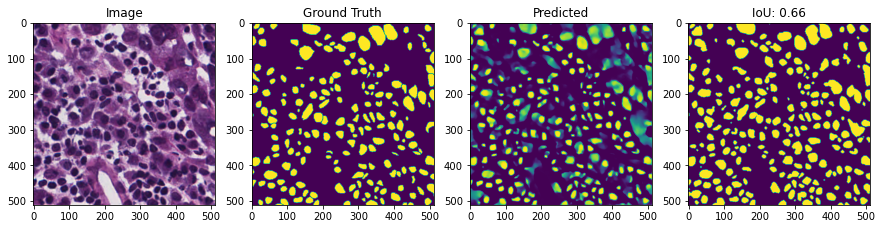

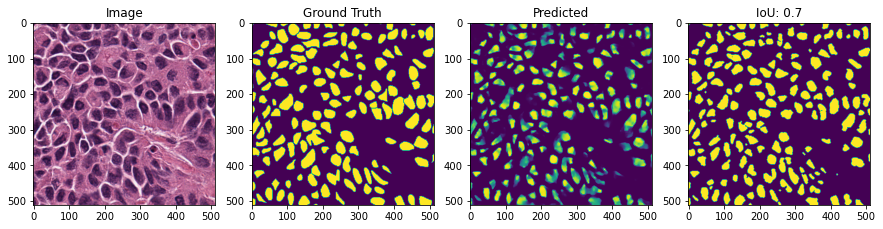

In [11]:
cutoff = 0.5
size_limit = 5/4
display_result(model, Monuseg(), 5)
print("Mean IOU:", round(mean_iou(Monuseg(), 100), 3))

### Bns

/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/imgaug/augmentables/heatmaps.py:71: UserWarning: Value range of heatmap was chosen to be (0.00000000, 1.00000000), but found actual min/max of (0.00000000, 9.23116302). Array will be clipped to chosen value range.
  ia.warn(


Mean IOU: 0.442


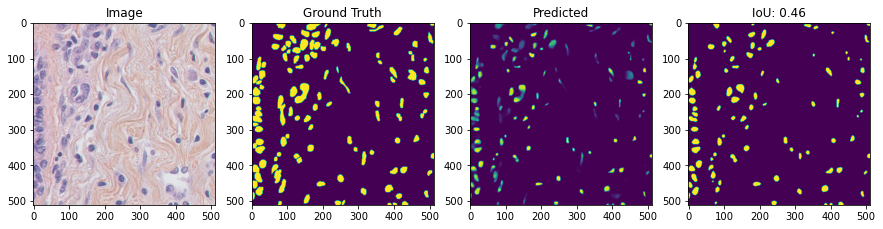

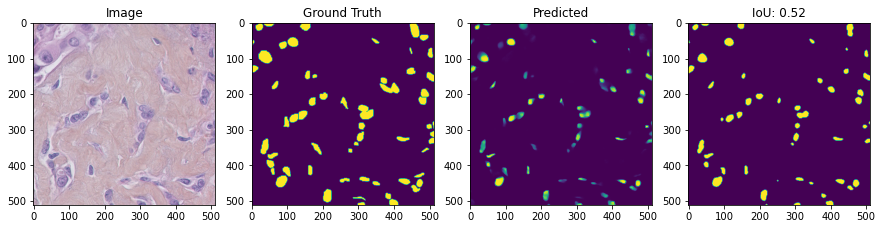

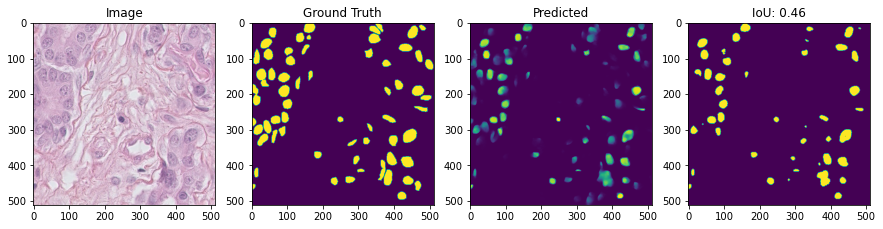

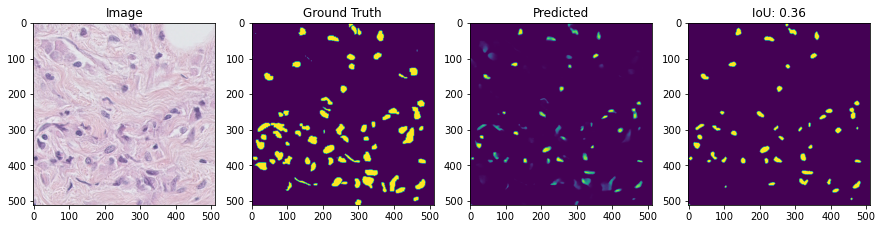

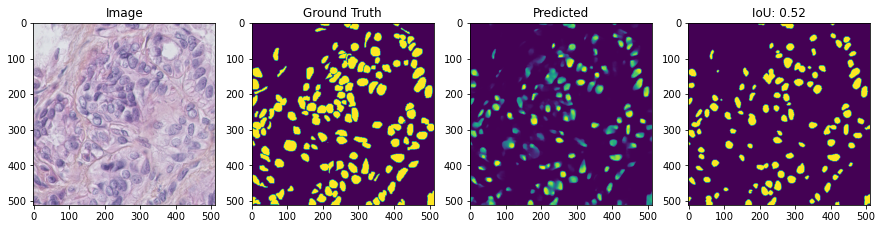

In [12]:
size_limit = 5/4
display_result(model, Bns(), 5)
print("Mean IOU:", round(mean_iou(Bns(), 100), 3))

### Quip validation

<ipython-input-5-758f1dad7fb7>:11: RuntimeWarning: invalid value encountered in long_scalars
  return intersection / union


Mean IOU: 0.705


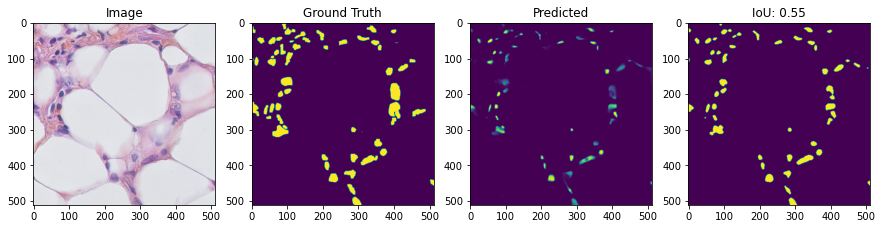

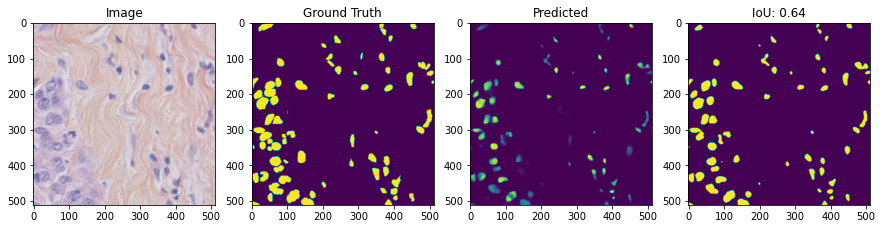

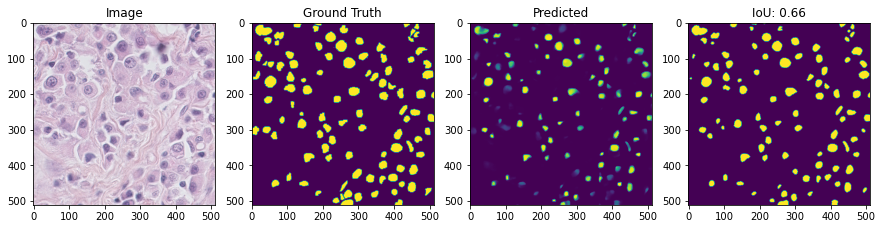

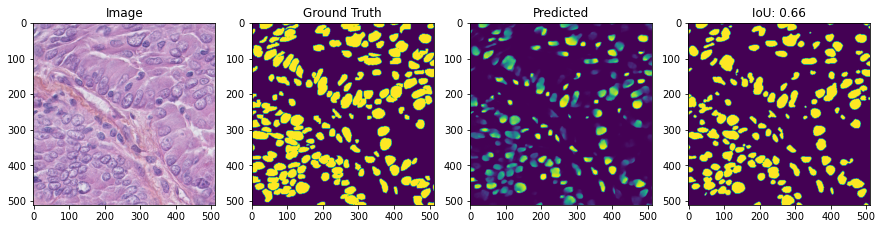

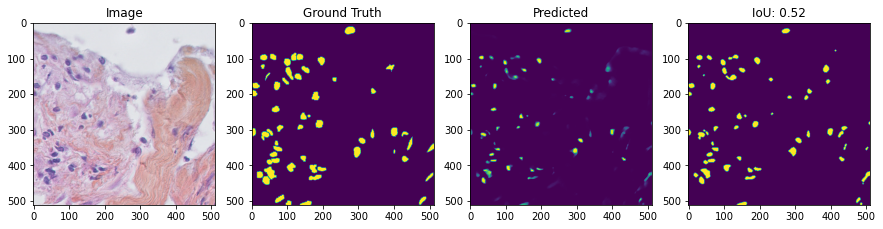

In [8]:
ds_val = Quip(n_min = 1900, n_max=2000) # Images not used during training
ds_val.aug_size = len(ds_val.ids)

# Saving memory
res = []
for i in range(10):
    random.shuffle(ds_val.ids)
    res.append(mean_iou(ds_val, 10))
    
print("Mean IOU:", round(np.mean(res), 3))
display_result(model, Bns(), 5)

## Predict on TNBC-cohort set

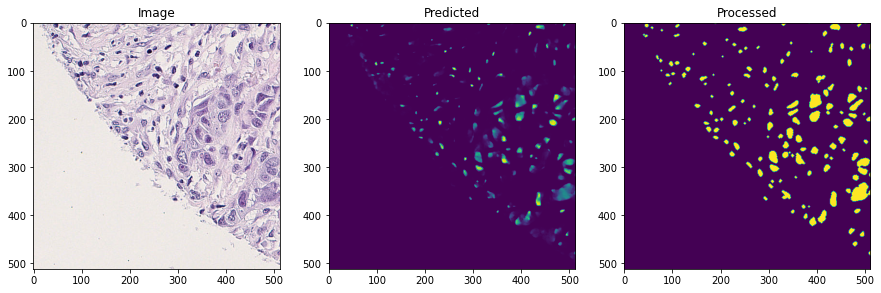

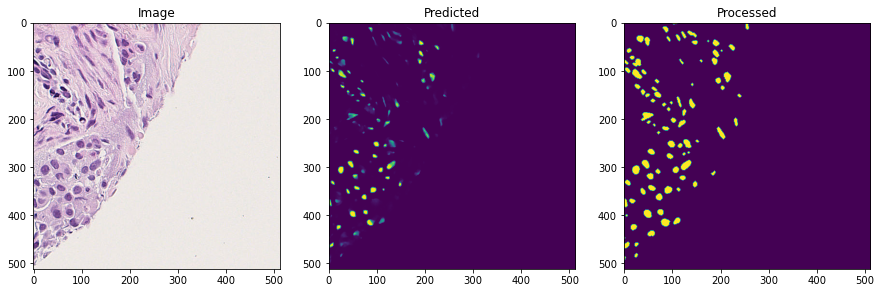

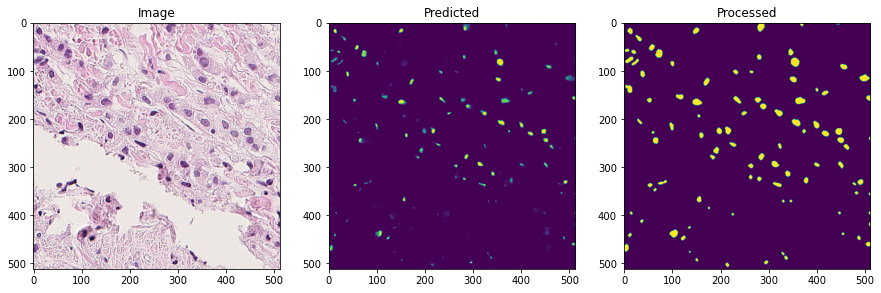

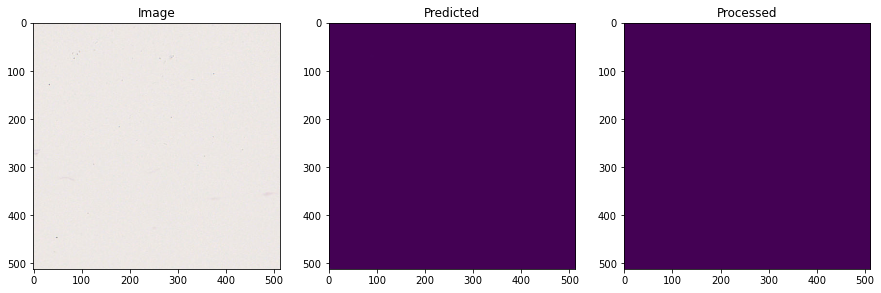

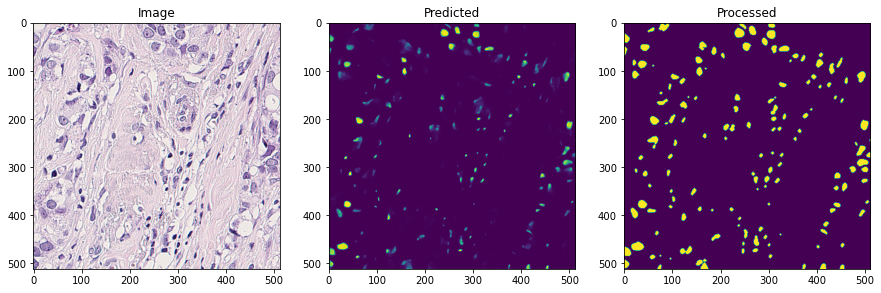

In [12]:
from dataset import TNBC1, TNBC2
from tqdm import tqdm

tnbc = TNBC1()

def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield np.array(lst[i : i + n])

images = [tnbc.load_image(pid) for pid in tnbc.ids[40:45]]
for img_b in chunks(seq(images=images), c.BATCH_SIZE):
    prediction = model.predict(img_b)
    for img, pred in zip(img_b, prediction):
        plt.figure(figsize=(15, 8))
        plt.subplot(131)
        plt.imshow(img)
        plt.title("Image")

        plt.subplot(132)
        plt.imshow(pred[:, :, 1])
        plt.title("Predicted")

        plt.subplot(133)
        pred = post_processing(pred[..., 1], 0.2, 5)
        plt.imshow(pred)
        plt.title("Processed")
        